# Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, \
                                        Lambda, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, \
                    classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

plt.style.use('ggplot')

In [ ]:
os.chdir("/content/drive/MyDrive/DiabeticRetinopathyDetection")

# Data

## Loading labeled data

In [ ]:
labeled_data_features = np.load("data/processed/train/features/labeled_data_features.npy")
labeled_data_labels = pd.read_csv('data/ext/trainlabels.csv')['level'].values

print("Total labeled data features shape", labeled_data_features.shape)
print("labeled data labels shape", labeled_data_labels.shape)

_, labeled_data_features, _, labeled_data_labels = train_test_split(
    labeled_data_features, labeled_data_labels, test_size=0.2, stratify=labeled_data_labels, random_state=42)

print(f"20% labeled data features shape", labeled_data_features.shape)
print(f"20% labeled data labels shape", labeled_data_labels.shape)

Total labeled data features shape (35122, 51200)
labeled data labels shape (35122,)
20% labeled data features shape (7025, 51200)
20% labeled data labels shape (7025,)


Class 0: 5162 samples
Class 1: 488 samples
Class 2: 1058 samples
Class 3: 175 samples
Class 4: 142 samples


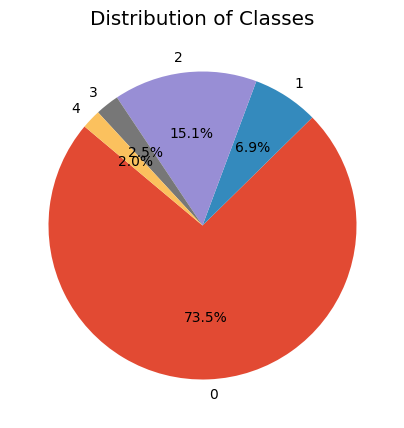

In [ ]:
unique_classes, class_counts = np.unique(labeled_data_labels, return_counts=True)

for class_name, count in zip(unique_classes, class_counts):
    print(f"Class {class_name}: {count} samples")

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=unique_classes, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

## loading reliable data

In [ ]:
reliable_data_features = np.load("data/sampled/reliable/reliable_samples.npy")
reliable_data_labels = np.load("data/sampled/reliable/reliable_pseudo_labels.npy")

print("reliable data features shape", reliable_data_features.shape)
print("reliable data labels shape", reliable_data_labels.shape)

reliable data features shape (41425, 51200)
reliable data labels shape (41425,)


Class 0: 33583 samples
Class 1: 2383 samples
Class 2: 4414 samples
Class 3: 689 samples
Class 4: 356 samples


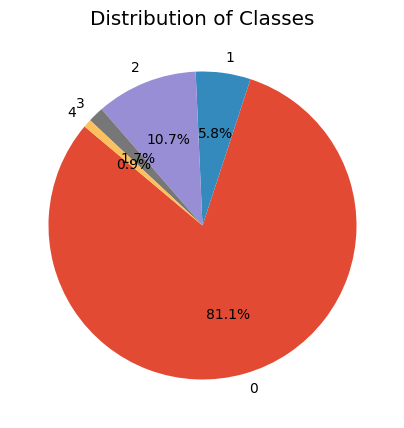

In [ ]:
unique_classes, class_counts = np.unique(reliable_data_labels, return_counts=True)

for class_name, count in zip(unique_classes, class_counts):
    print(f"Class {class_name}: {count} samples")

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=unique_classes, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

## loading unreliable data

In [ ]:
unreliable_data_features = np.load("data/sampled/unreliable/unreliable_data_features.npy")
unreliable_data_labels = np.load("data/sampled/unreliable/unreliable_pseudo_labels.npy")

print("Unreliable data features shape", unreliable_data_features.shape)
print("Unreliable data labels shape", unreliable_data_labels.shape)

Unreliable data features shape (12145, 51200)
Unreliable data labels shape (12145,)


Class 0: 2270 samples
Class 1: 3059 samples
Class 2: 2486 samples
Class 3: 2072 samples
Class 4: 2258 samples


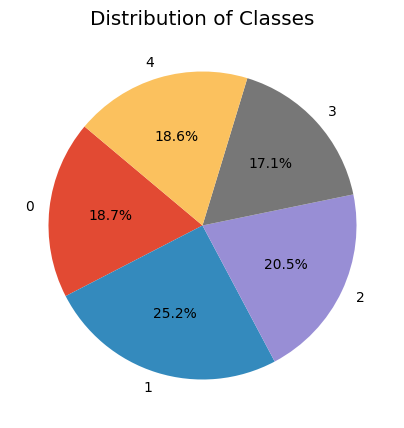

In [ ]:
unique_classes, class_counts = np.unique(unreliable_data_labels, return_counts=True)

for class_name, count in zip(unique_classes, class_counts):
    print(f"Class {class_name}: {count} samples")

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=unique_classes, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

## Mixing labeled and Unlabeled reliable data

Combined data features shape (60595, 51200)
Combined data labels shape (60595,)
Class 0: 41015 samples
Class 1: 5930 samples
Class 2: 7958 samples
Class 3: 2936 samples
Class 4: 2756 samples


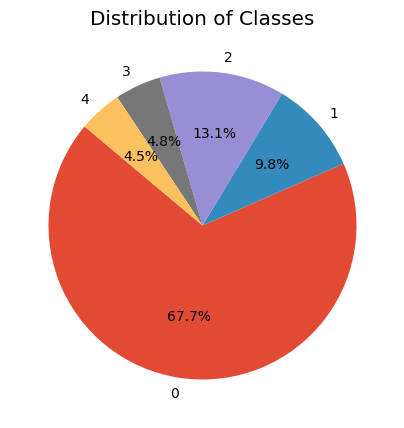

In [ ]:
# Combine labeled and pseudo-labeled data
features = np.vstack((labeled_data_features, reliable_data_features, unreliable_data_features))
labels = np.concatenate((labeled_data_labels, reliable_data_labels, unreliable_data_labels))


print("Combined data features shape", features.shape)
print("Combined data labels shape", labels.shape)

unique_classes, class_counts = np.unique(labels, return_counts=True)

for class_name, count in zip(unique_classes, class_counts):
    print(f"Class {class_name}: {count} samples")

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=unique_classes, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Classes')
plt.show()

In [ ]:
np.save('data/combo/model2/features.npy', features)
np.save('data/combo/model2/labels.npy', labels)

## Balancing via SMOTE

In [ ]:
features = np.load('data/combo/model2/features.npy')
labels = np.load('data/combo/model2/labels.npy')

In [ ]:
# Set the target number of samples for each class
target_samples = 10000

# Upsample the minority classes (classes 1, 2, 3, and 4) using SMOTE
smote = SMOTE(sampling_strategy={1: 15000, 2: 20000, 3: target_samples, 4: target_samples})
oversampled_features, oversampled_labels = smote.fit_resample(features, labels)

# Downsample the majority class (class 0) using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy={0: 30000})
undersampled_features, undersampled_labels = undersampler.fit_resample(oversampled_features, oversampled_labels)

print("Class distribution after balancing:", Counter(undersampled_labels))
print("Shape of oversampled features:", undersampled_labels.shape)
print("Shape of oversampled labels:", undersampled_labels.shape)

Class distribution after balancing: Counter({0: 30000, 2: 20000, 1: 15000, 3: 10000, 4: 10000})
Shape of oversampled features: (85000,)
Shape of oversampled labels: (85000,)


In [ ]:
np.save("data/combo/model2/balanced_features.npy", undersampled_features)
np.save("data/combo/model2/balanced_labels.npy", undersampled_labels)

print("Features saved at data/combo/model2/balanced_features.npy")
print("Labels saved at data/combo/model2/balanced_labels.npy")

Features saved at data/combo/model2/balanced_features.npy
Labels saved at data/combo/model2/balanced_labels.npy


## Data Split

In [ ]:
balanced_features = np.load('data/combo/model2/balanced_features.npy')
balanced_labels = np.load('data/combo/model2/balanced_labels.npy')

print("Class distribution:", Counter(balanced_labels))
print("Shape of balanced features:", balanced_labels.shape)
print("Shape of balanced labels:", balanced_labels.shape)

Class distribution: Counter({0: 30000, 2: 20000, 1: 15000, 3: 10000, 4: 10000})
Shape of balanced features: (85000,)
Shape of balanced labels: (85000,)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    balanced_features, balanced_labels, test_size=0.25, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (63750, 51200)
y_train shape (63750,)
X_val shape (17000, 51200)
y_val shape (17000,)
X_test shape (4250, 51200)
y_test shape (4250,)


In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
np.save('data/combo/model2/X_train.npy', X_train)
np.save('data/combo/model2/y_train.npy', y_train)

np.save('data/combo/model2/X_val.npy', X_val)
np.save('data/combo/model2/y_val.npy', y_val)

np.save('data/combo/model2/X_test.npy', X_test)
np.save('data/combo/model2/y_test.npy', y_test)

## Breaking training data

In [ ]:
X_train = np.load('data/combo/model2/X_train.npy')
y_train = np.load('data/combo/model2/y_train.npy')

In [ ]:
X_train_a, X_train_b, y_train_a, y_train_b = train_test_split(
    X_train, y_train, test_size=0.5, random_state=42
)

print("X_train shape", X_train_a.shape)
print("y_train shape", y_train_a.shape)
print("X_val shape", X_train_b.shape)
print("y_val shape", y_train_b.shape)

X_train shape (31875, 51200)
y_train shape (31875, 5)
X_val shape (31875, 51200)
y_val shape (31875, 5)


In [ ]:
np.save('data/combo/model2/X_train_a.npy', X_train_a)
np.save('data/combo/model2/y_train_a.npy', y_train_a)

np.save('data/combo/model2/X_train_b.npy', X_train_b)
np.save('data/combo/model2/y_train_b.npy', y_train_b)

# Model

## Training with dataset a

In [ ]:
X_train_a = np.load('data/combo/model2/X_train_a.npy')
y_train_a = np.load('data/combo/model2/y_train_a.npy')

X_val = np.load('data/combo/model2/X_val.npy')
y_val = np.load('data/combo/model2/y_val.npy')

In [ ]:
model_a = Sequential([
    Dense(1024, input_shape=(X_train_a.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(512),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(256),
    BatchNormalization(),
    Dropout(0.2),
    ReLU(),

    Dense(5, activation='softmax')
])

In [ ]:
model_a.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history_a = model_a.fit(
    X_train_a, y_train_a,
    epochs=50,
    validation_data=(X_val, y_val)
)

Epoch 1/80
997/997 [==============================] - 37s 33ms/step - loss: 1.0827 - accuracy: 0.5643 - val_loss: 0.8950 - val_accuracy: 0.6416
Epoch 2/80
997/997 [==============================] - 24s 24ms/step - loss: 0.8003 - accuracy: 0.6868 - val_loss: 0.7800 - val_accuracy: 0.6882
Epoch 3/80
997/997 [==============================] - 24s 24ms/step - loss: 0.6312 - accuracy: 0.7556 - val_loss: 0.7313 - val_accuracy: 0.7262
Epoch 4/80
997/997 [==============================] - 25s 25ms/step - loss: 0.5122 - accuracy: 0.8035 - val_loss: 0.6880 - val_accuracy: 0.7534
Epoch 5/80
997/997 [==============================] - 25s 25ms/step - loss: 0.4078 - accuracy: 0.8459 - val_loss: 0.6701 - val_accuracy: 0.7655
Epoch 6/80
997/997 [==============================] - 24s 25ms/step - loss: 0.3412 - accuracy: 0.8728 - val_loss: 0.7070 - val_accuracy: 0.7626
Epoch 7/80
997/997 [==============================] - 24s 25ms/step - loss: 0.2786 - accuracy: 0.8966 - val_loss: 0.6964 - val_accuracy:

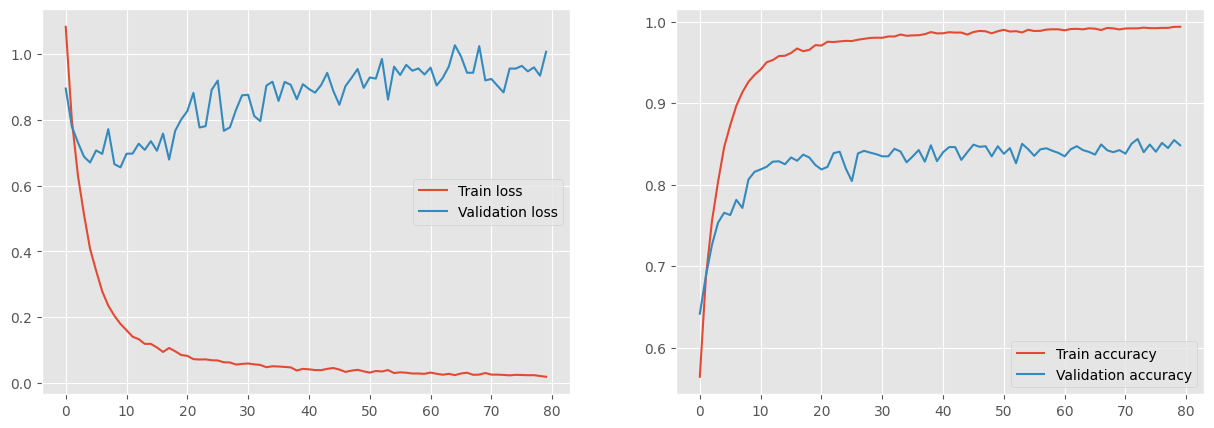

In [ ]:
r = pd.DataFrame(history_a.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
model_a.save('models/model2/model_a.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Training on dataset b

In [ ]:
X_train_b = np.load('data/combo/model2/X_train_b.npy')
y_train_b = np.load('data/combo/model2/y_train_b.npy')

X_val = np.load('data/combo/model2/X_val.npy')
y_val = np.load('data/combo/model2/y_val.npy')

In [ ]:
model_b = tf.keras.models.load_model('models/model2/model_a.h5')

In [ ]:
model_b.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history_b = model_b.fit(
    X_train_b, y_train_b,
    epochs=30,
    validation_data=(X_val, y_val)
)

Epoch 1/30
997/997 [==============================] - 36s 31ms/step - loss: 0.5769 - accuracy: 0.8385 - val_loss: 0.3712 - val_accuracy: 0.8761
Epoch 2/30
997/997 [==============================] - 23s 23ms/step - loss: 0.3399 - accuracy: 0.8800 - val_loss: 0.3409 - val_accuracy: 0.8834
Epoch 3/30
997/997 [==============================] - 24s 24ms/step - loss: 0.2528 - accuracy: 0.9079 - val_loss: 0.3408 - val_accuracy: 0.8864
Epoch 4/30
997/997 [==============================] - 23s 24ms/step - loss: 0.1971 - accuracy: 0.9276 - val_loss: 0.3426 - val_accuracy: 0.8945
Epoch 5/30
997/997 [==============================] - 24s 24ms/step - loss: 0.1529 - accuracy: 0.9447 - val_loss: 0.3542 - val_accuracy: 0.8991
Epoch 6/30
997/997 [==============================] - 24s 24ms/step - loss: 0.1175 - accuracy: 0.9581 - val_loss: 0.3986 - val_accuracy: 0.8949
Epoch 7/30
997/997 [==============================] - 23s 23ms/step - loss: 0.0960 - accuracy: 0.9647 - val_loss: 0.4161 - val_accuracy:

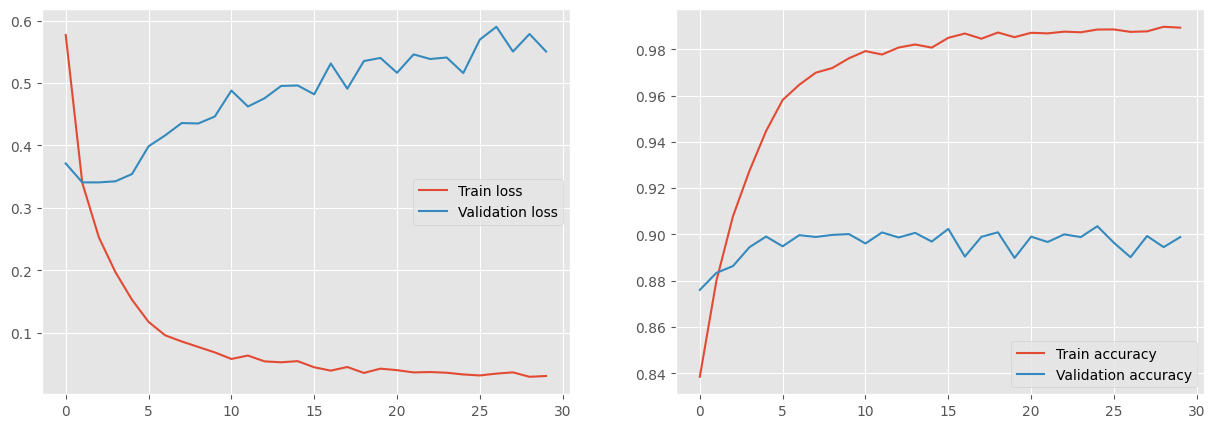

In [ ]:
r = pd.DataFrame(history_b.history)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(r.index, r['loss'], label='Train loss')
ax[0].plot(r.index, r['val_loss'], label='Validation loss')
ax[1].plot(r.index, r['accuracy'], label='Train accuracy')
ax[1].plot(r.index, r['val_accuracy'], label='Validation accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
model_b.save('models/model2/model_b.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Testing

In [ ]:
# X_train = np.load('data/combo/model2/X_train.npy')
# y_train = np.load('data/combo/model2/y_train.npy')

# X_val = np.load('data/combo/model2/X_val.npy')
# y_val = np.load('data/combo/model2/y_val.npy')

X_test = np.load('data/combo/model2/X_test.npy')
y_test = np.load('data/combo/model2/y_test.npy')

# model = tf.keras.models.load_model('models/model2/model_b.h5')

In [ ]:
# train_loss, train_acc = model.evaluate(X_train, y_train)
# val_loss, val_acc = model.evaluate(X_val, y_val)
# test_loss, test_acc = model.evaluate(X_test, y_test)

# print('Training Accuracy:', train_acc)
# print('Validation Accuracy:', val_acc)
# print('Testing Accuracy:', test_acc)

In [ ]:
y_pred = model_b.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

133/133 [==============================] - 1s 5ms/step


In [ ]:
# Calculate precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.896
Precision: 0.8956712612455431
Recall: 0.896
F1 score: 0.8957234233759376


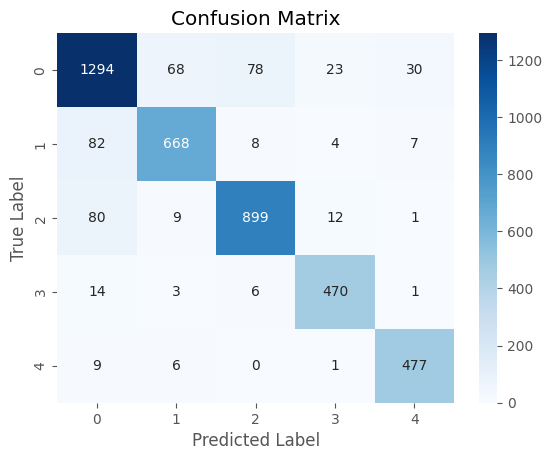

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1493
           1       0.89      0.87      0.88       769
           2       0.91      0.90      0.90      1001
           3       0.92      0.95      0.94       494
           4       0.92      0.97      0.95       493

    accuracy                           0.90      4250
   macro avg       0.90      0.91      0.91      4250
weighted avg       0.90      0.90      0.90      4250

